In [ ]:
%load_ext tensorboard
%tensorflow_version 2.x

# Init global infos
import numpy as np
from tensorflow import keras
from keras.utils import np_utils
import matplotlib.pyplot as plt
import pandas as pd
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf
import os
import pathlib
import skimage
from numpy import load
from numpy import save


batch_size = 256
num_epochs = 10
weightLoss = 0.07
loadModelBool = False
saveModelBool = False

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# load data
np_woman_train_vgg = load('drive/My Drive/Data/np_woman_train_vgg.npy')
np_woman_val_vgg = load('drive/My Drive/Data/np_woman_val_vgg.npy')
np_woman_test_vgg = load('drive/My Drive/Data/np_woman_test_vgg_2.npy')

np_man_train_vgg = load('drive/My Drive/Data/np_man_train_vgg.npy')
np_man_val_vgg = load('drive/My Drive/Data/np_man_val_vgg.npy')
np_man_test_vgg = load('drive/My Drive/Data/np_man_test_vgg_2.npy')

y_train_woman = load('drive/My Drive/Data/y_woman_train_vgg1.npy')
y_val_woman = load('drive/My Drive/Data/y_woman_val_vgg1.npy')
y_test_woman = load('drive/My Drive/Data/y_woman_test_vgg1.npy')

y_train_man = load('drive/My Drive/Data/y_man_train_vgg1.npy')
y_val_man = load('drive/My Drive/Data/y_man_val_vgg1.npy')
y_test_man = load('drive/My Drive/Data/y_man_test_vgg1.npy')

In [ ]:
y_train_woman_zeros = np.zeros((y_train_woman.shape[0],1))
y_train_woman_ = np.hstack((y_train_woman, y_train_woman_zeros))
y_train_man_ones = np.ones((y_train_man.shape[0],1))
y_train_man_ = np.hstack((y_train_man, y_train_man_ones))

In [ ]:
np_woman_train_vgg_target = np_woman_train_vgg[:5000]
y_train_woman_target = y_train_woman[:5000]

In [ ]:
inputs = keras.layers.Input(shape=(2048))
dense2 = keras.layers.Dense(124, activation='relu')(inputs)
output = keras.layers.Dense(2, activation='softmax')(dense2)

model = keras.Model(inputs=inputs, outputs=[dense2, output])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense (Dense)                (None, 124)               254076    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 250       
Total params: 254,326
Trainable params: 254,326
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Load already existing model, if wanted (e.g. for further training)
if loadModelBool:
  model = tf.keras.models.load_model('drive/My Drive/saved_model/cross_model_normal_hl124')
  dist_losses = load('drive/My Drive/Data/cross_dist_losses_hl124_07.npy').tolist()
  train_accuracy = load('drive/My Drive/Data/cross_train_accuracy_hl124_07.npy').tolist()
  cross_entropy_losses = load('drive/My Drive/Data/cross_cross_entropy_losses_hl124_07.npy').tolist()
  val_accuracy = load('drive/My Drive/Data/cross_val_accuracy_hl124_07.npy').tolist()
else: 
  dist_losses = []
  cross_entropy_losses = []
  train_accuracy = []
  val_accuracy = []

In [ ]:
# Instantiate an optimizer to train the model.
optimizer = tf.compat.v1.train.AdamOptimizer()
# Instantiate a loss function.
loss_cc = keras.losses.BinaryCrossentropy(from_logits=True)
# Prepare the metrics.
train_acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()

# Prepare the training datasets
train_dataset = tf.data.Dataset.from_tensor_slices((np.concatenate([np_woman_train_vgg, np_man_train_vgg], axis=0), np.concatenate([y_train_woman_,y_train_man_],axis=0)))
train_dataset = train_dataset.shuffle(buffer_size=200000).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((np.concatenate([np_woman_val_vgg,np_man_val_vgg], axis=0), np.concatenate([y_val_woman,y_val_man],axis=0)))
val_dataset = val_dataset.shuffle(buffer_size=batch_size).batch(batch_size)

In [ ]:
def distance_loss(predictions, y, predictions_target, y_target, classes_y):
    def some_function(tensor):
      y_source = tensor[1]
      equal =  tf.math.equal(y_source, y_target)
      equal_all = tf.reduce_all(equal, axis=1)
      contains = tf.boolean_mask(predictions_target, equal_all)
      distance = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(tensor[0], contains)), axis=1))
      # nearest k points
      closest_distance,_ = tf.math.top_k(tf.negative(distance), k=1)
      return tf.abs(closest_distance)
    y_equal_source =  tf.math.equal(classes_y, tf.constant(1, dtype=tf.float32))
    y_equal_all_source = tf.reduce_all(y_equal_source, axis=1)
    predictions_source = tf.boolean_mask(predictions, y_equal_all_source)
    y_source = tf.boolean_mask(y, y_equal_all_source)
    d = tf.map_fn(some_function, (predictions_source,y_source), dtype=tf.float32)
    return tf.math.reduce_sum(d)

In [ ]:
def train_step(model, optimizer, x_batch, y_batch, x_train_target, y_train_target, classes_y):

    with tf.GradientTape() as tape:   
      hidden_logits = model(x_batch, training=True)[0]
      hidden_logits_target = model(x_train_target, training=True)[0]
      loss_dist = distance_loss(hidden_logits, y_batch, hidden_logits_target, y_train_target, classes_y)
      logits = model(x_batch, training=True)[1]
      loss_cross = loss_cc(y_batch, logits)
      loss_value = loss_cross + weightLoss*loss_dist

    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Update training metric.
    train_acc_metric(y_batch, logits)
    return loss_value, loss_dist, loss_cross

In [ ]:
for epoch in range(num_epochs):
    print('Start of epoch %d' % (epoch,))
    # Iterate over the batches of the dataset.
    step = 0

    for (x_batch, y_batch) in train_dataset:
      
      classes_y = tf.cast(tf.strided_slice(tf.identity(y_batch), [0,-1], [y_batch.shape[0],y_batch.shape[0]], [1,1]),dtype=tf.float32)
      y_batch_ = tf.cast(tf.strided_slice(tf.identity(y_batch), [0,0], [y_batch.shape[0],-1], [1,1]),dtype=tf.float32)

      loss_value, loss_dist, loss_cross = train_step(model, optimizer, x_batch, y_batch_, tf.constant(np_woman_train_vgg_target, dtype=tf.float32), tf.constant(y_train_woman_target, dtype=tf.float32), classes_y)

      # Log every 250 batches.
      if step % 250 == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Distance loss and cross entropy loss at step %s: %s  %s' % (step, float(loss_dist),float(loss_cross)))

      step +=1
    dist_losses.append(float(loss_dist))
    cross_entropy_losses.append(float(loss_cross))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print('Training acc over epoch: %s' % (float(train_acc),))
    train_accuracy.append(float(train_acc))

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val)[1]
        # Update val metrics
        val_acc_metric(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    print('Validation acc: %s' % (float(val_acc),))
    val_accuracy.append(float(val_acc))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

Start of epoch 0
Training loss (for one batch) at step 0: 0.7131795883178711
Distance loss and cross entropy loss at step 0: 0.6115014553070068  0.6703745126724243
Training loss (for one batch) at step 250: 0.7188089489936829
Distance loss and cross entropy loss at step 250: 0.5088013410568237  0.6831928491592407
Training loss (for one batch) at step 500: 0.7391139268875122
Distance loss and cross entropy loss at step 500: 0.7999710440635681  0.6831159591674805
Training acc over epoch: 0.6457824110984802
Validation acc: 0.6265163421630859
Start of epoch 1
Training loss (for one batch) at step 0: 0.7359494566917419
Distance loss and cross entropy loss at step 0: 0.7193929553031921  0.6855919361114502
Training loss (for one batch) at step 250: 0.7030187249183655
Distance loss and cross entropy loss at step 250: 0.4897048771381378  0.668739378452301
Training loss (for one batch) at step 500: 0.7148102521896362
Distance loss and cross entropy loss at step 500: 0.4621967673301697  0.6824564

In [ ]:
if saveModelBool:
  model.save('drive/My Drive/saved_model/cross_model_hl124_07') 
  save('drive/My Drive/Data/cross_train_accuracy_hl124_07.npy', train_accuracy)
  save('drive/My Drive/Data/cross_dist_losses_hl124_07.npy', dist_losses)
  save('drive/My Drive/Data/cross_cross_entropy_losses_hl124_07.npy', cross_entropy_losses)
  save('drive/My Drive/Data/cross_val_accuracy_hl124_07.npy', val_accuracy)

INFO:tensorflow:Assets written to: drive/My Drive/saved_model/cross_model_hl124_07/assets


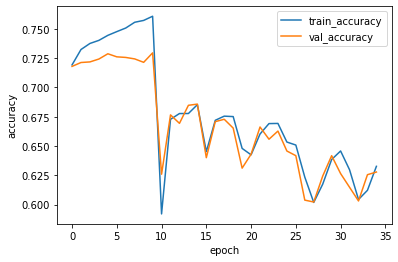

In [ ]:
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='best')
plt.show()

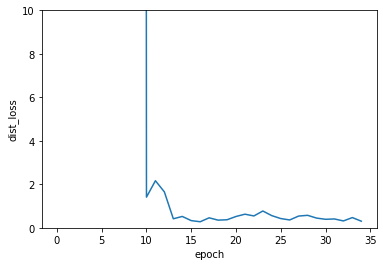

In [ ]:
plt.plot(dist_losses)
plt.ylim(0,10)
plt.ylabel('dist_loss')
plt.xlabel('epoch')
plt.show()

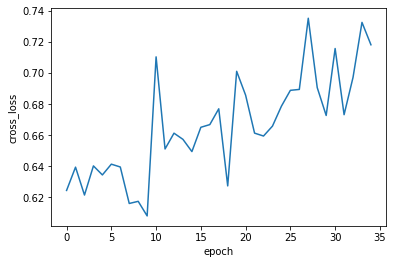

In [ ]:
plt.plot(cross_entropy_losses)
plt.ylabel('cross_loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# retrain last layer of fair model to be able to easily predict samples in the 
# following steps (for calculating confusion matrix)
model_2 = keras.models.clone_model(model)
model_2.set_weights(model.get_weights()) 

model_2._layers.pop()
for layer in model_2.layers: layer.trainable = False  

# recover the output from the last layer in the model and use as input to new Dense layer
last = model_2.layers[-1].output
output = keras.layers.Dense(2, activation="softmax", name="output")(last)
model_2 = keras.models.Model(model_2.input, output)

for layer in model_2.layers:
    print(layer, layer.trainable)
    
model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics={"output":'accuracy'})

model_2.summary()

history = model_2.fit(np.concatenate((np_man_train_vgg,np_woman_train_vgg)), np.concatenate((y_train_man, y_train_woman)),epochs=5,
    shuffle=True,
    verbose=1)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f3808ff2da0> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f38086e8668> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f388e202f60> True
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 124)               254076    
_________________________________________________________________
output (Dense)               (None, 2)                 250       
Total params: 254,326
Trainable params: 250
Non-trainable params: 254,076
_________________________________________________________________
Epoch 1/5
5087/5087 [==============================] - 13s 2ms/step - loss: 0.5197 - accuracy: 0.7589
Epoch 2/5
5087/5087 [=====================

In [ ]:
# calculate confusion matrix and fairness measures
y_pred_female = model_2.predict(np_woman_test_vgg)
y_pred_female = np.argmax(y_pred_female, axis=1)

y_pred_male = model_2.predict(np_man_test_vgg)
y_pred_male = np.argmax(y_pred_male, axis=1)

y_test_female_binary = np.argmax(y_test_woman, axis=1)
y_test_male_binary = np.argmax(y_test_man, axis=1)

from sklearn.metrics import confusion_matrix
tn_female, fp_female, fn_female, tp_female = confusion_matrix(y_test_female_binary, y_pred_female).ravel()
tn_male, fp_male, fn_male, tp_male = confusion_matrix(y_test_male_binary, y_pred_male).ravel()

# female
prob_true_beutel_female = (tp_female + fp_female)/y_test_woman.shape[0]
print("prob_1 female (beutel):", prob_true_beutel_female)
acc_female = (tp_female + tn_female)/y_test_woman.shape[0]
print("acc female:", acc_female)
tpr_female = tp_female/(tp_female + fn_female)
print("tpr female:",tpr_female)
ppv_female = tp_female/(tp_female + fp_female)
print("ppv female:",ppv_female)
tnr_female = tn_female/(tn_female + fp_female)
print("tnr female:",tnr_female)

print("---------------------------------------------------")
# male
prob_true_beutel_male = (tp_male + fp_male)/y_test_man.shape[0]
print("prob_1 male (beutel):", prob_true_beutel_male)
acc_male = (tp_male + tn_male)/y_test_man.shape[0]
print("acc male:", acc_male)
tpr_male = tp_male/(tp_male + fn_male)
print("tpr male:", tpr_male)
ppv_male = tp_male/(tp_male + fp_male)
print("ppv male:",ppv_male)
tnr_male = tn_male/(tn_male + fp_male)
print("tnr male:",tnr_male)
print("---------------------------------------------------")

parity_gap_beutel = abs(prob_true_beutel_female - prob_true_beutel_male)
pred_parity = abs(ppv_female - ppv_male)
equal_opportunity = abs(tpr_female - tpr_male) # = equality_gap_1
equality_gap_0_beutel = abs(tnr_female - tnr_male)
accuracy_gap = abs(acc_female - acc_male)

print("parity gap (beutel):", parity_gap_beutel)
print("predictive parity:", pred_parity)
print("equal opportunity (equality gap 1 (beutel)):", equal_opportunity)
print("equality gap 0 (beutel):", equality_gap_0_beutel)
print("accuracy gap:", accuracy_gap)



prob_1 female (beutel): 0.7410794480280886
acc female: 0.570343757654936
tpr female: 0.7388527054108216
ppv female: 0.6499559277214632
tnr female: 0.2547501759324419
---------------------------------------------------
prob_1 male (beutel): 0.26843810758263126
acc male: 0.6159429682436811
tpr male: 0.2669801462904911
ppv male: 0.24674070497344278
tnr male: 0.7310808481296328
---------------------------------------------------
parity gap (beutel): 0.4726413404454573
predictive parity: 0.40321522274802035
equal opportunity (equality gap 1 (beutel)): 0.4718725591203305
equality gap 0 (beutel): 0.4763306721971909
accuracy gap: 0.045599210588745165


In [ ]:
# Add sensitive data (gender attribute) to fair representation of data and
# retrain last layer on this new data, look at weights to see what impact the 
# readded sensitive attribute has on the prediction

rep_layer_male = model(np_man_train_vgg)[0]
rep_layer_female = model(np_woman_train_vgg)[0]

rep_train_x = np.concatenate((rep_layer_male, rep_layer_female))
train_y = np.concatenate((y_train_man, y_train_woman))

male_train_sens = np.ones((rep_layer_male.shape[0],1))
female_train_sens = np.zeros((rep_layer_female.shape[0],1))

train_sens = np.concatenate((male_train_sens, female_train_sens))

rep_layer_male_test = model(np_man_test_vgg)[0]
rep_layer_female_test = model(np_woman_test_vgg)[0]

rep_test_x = np.concatenate((rep_layer_male_test, rep_layer_female_test))
test_y = np.concatenate((y_test_man, y_test_woman))

male_test_sens = np.ones((rep_layer_male_test.shape[0],1))
female_test_sens = np.zeros((rep_layer_female_test.shape[0],1))

test_sens = np.concatenate((male_test_sens, female_test_sens))

from sklearn.utils import shuffle
rep_train_x, train_sens, train_y = shuffle(rep_train_x, train_sens , train_y)
rep_test_x, test_sens, test_y = shuffle(rep_test_x, test_sens , test_y)

In [ ]:
# retrain last layer on this new data, look at weights to see what impact the 
# readded sensitive attribute has on the prediction
input2 = keras.layers.Input(shape=124)
dense2_1 = keras.layers.Dense(1)(input2)
input_sens = keras.layers.Input(shape=1, name='input_sens')
mergedLayer = keras.layers.concatenate([dense2_1, input_sens], axis = 1)
output2 = keras.layers.Dense(2, activation='softmax')(mergedLayer)

model2 = keras.Model(inputs=[input2, input_sens], outputs=[output2])

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.summary()

history = model2.fit([rep_train_x, train_sens], train_y,
                     batch_size=batch_size,
                     epochs=20,
                     verbose=1,
                     shuffle = True)
score = model2.evaluate([rep_test_x, test_sens], test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 124)]        0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 1)            125         input_7[0][0]                    
__________________________________________________________________________________________________
input_sens (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 2)            0           dense_9[0][0]                    
                                                                 input_sens[0][0]          

In [ ]:
for layer in model2.layers: print(layer.name, layer.get_weights())

input_7 []
dense_9 [array([[ 0.19587936],
       [ 0.0103063 ],
       [-0.00107592],
       [-0.07299263],
       [-0.04146337],
       [ 0.11066469],
       [-0.11518171],
       [-0.08463353],
       [-0.0604966 ],
       [ 0.02795283],
       [-0.07155934],
       [ 0.00816722],
       [ 0.07029458],
       [-0.0992566 ],
       [-0.02562931],
       [-0.04850153],
       [ 0.01439107],
       [ 0.09861846],
       [-0.06999564],
       [-0.08666233],
       [ 0.0209106 ],
       [-0.20012379],
       [ 0.07748165],
       [ 0.10096379],
       [ 0.14053626],
       [ 0.06043467],
       [-0.07380931],
       [-0.10708738],
       [-0.17400253],
       [ 0.0879413 ],
       [-0.07201605],
       [-0.0310555 ],
       [ 0.02521959],
       [-0.19154164],
       [-0.10173278],
       [ 0.13114823],
       [ 0.16421738],
       [-0.04638778],
       [ 0.18061773],
       [ 0.7174801 ],
       [ 0.10817371],
       [ 0.05597572],
       [ 0.07331082],
       [ 0.13785106],
       [ 0.1

In [ ]:
# Get fair representation of data of trained model and plot the according histogram
intermediate_layer_model = keras.models.Model(inputs = model2.input, outputs = model2.get_layer("dense_6").output)
intermediate_output_male = intermediate_layer_model.predict([rep_layer_male_test, male_test_sens])
intermediate_output_female = intermediate_layer_model.predict([rep_layer_female_test, female_test_sens])

plt.hist(intermediate_output_female, density = True, alpha=0.5, label='female')
plt.hist(intermediate_output_male, density = True, alpha=0.5, label='male')
plt.xlabel("output representation layer")
plt.legend(loc='best')
plt.savefig("hist_rep1.png")

In [ ]:
# add sensitive attribute back to fair representation for retraining model to
# then easily get confusion matrix and fairness measures based on gender

rep_train_male_ones = np.ones((rep_layer_male.shape[0],1))
rep_layer_male_ = np.hstack((rep_layer_male, rep_train_male_ones))
rep_train_female_zeros = np.zeros((rep_layer_female.shape[0],1))
rep_layer_female_ = np.hstack((rep_layer_female, rep_train_female_zeros))

rep_layer_male_test = model(np_man_test_vgg, training=True)[0]
rep_layer_female_test = model(np_woman_test_vgg, training=True)[0]

rep_layer_male_test_ones = np.ones((rep_layer_male_test.shape[0],1))
rep_layer_male_test_ = np.hstack((rep_layer_male_test, rep_layer_male_test_ones))
rep_train_female_test_zeros = np.zeros((rep_layer_female_test.shape[0],1))
rep_layer_female_test_ = np.hstack((rep_layer_female_test, rep_train_female_test_zeros))

In [ ]:
input2 = keras.layers.Input(shape=125)
output2 = keras.layers.Dense(2, activation='softmax')(input2)

model3 = keras.Model(inputs=input2, outputs=[output2])

model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model3.summary()

history = model3.fit(np.concatenate((rep_layer_male_, rep_layer_female_)), np.concatenate((y_train_man, y_train_woman)),
                    batch_size=batch_size,
                    epochs=15,
                    verbose=1,
                    validation_split=0.1)
score = model3.evaluate(np.concatenate((rep_layer_male_test_, rep_layer_female_test_)), np.concatenate((y_test_man, y_test_woman)), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 125)]             0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 252       
Total params: 252
Trainable params: 252
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
573/573 [==============================] - 2s 3ms/step - loss: 0.5430 - accuracy: 0.7412 - val_loss: 0.5212 - val_accuracy: 0.7573
Epoch 2/15
573/573 [==============================] - 2s 3ms/step - loss: 0.5003 - accuracy: 0.7674 - val_loss: 0.5141 - val_accuracy: 0.7645
Epoch 3/15
573/573 [==============================] - 2s 3ms/step - loss: 0.4972 - accuracy: 0.7693 - val_loss: 0.5156 - val_accuracy: 0.7646
Epoch 4/15
573/573 [==============================] - 2s 3ms/step - loss: 0.4967 - accuracy: 0.7

In [ ]:
# calculate confusion matrix and fairness measures on model retrained on data with sensitive attribute

y_pred_female = model2.predict(rep_layer_female_test_)
y_pred_female = np.argmax(y_pred_female, axis=1)

y_pred_male = model3.predict(rep_layer_male_test_)
y_pred_male = np.argmax(y_pred_male, axis=1)

y_test_female_binary = np.argmax(y_test_woman, axis=1)
y_test_male_binary = np.argmax(y_test_man, axis=1)

from sklearn.metrics import confusion_matrix
tn_female, fp_female, fn_female, tp_female = confusion_matrix(y_test_female_binary, y_pred_female).ravel()
tn_male, fp_male, fn_male, tp_male = confusion_matrix(y_test_male_binary, y_pred_male).ravel()

## female
prob_true_beutel_female = (tp_female + fp_female)/y_test_woman.shape[0]
print("prob_1 female (beutel):", prob_true_beutel_female)
acc_female = (tp_female + tn_female)/y_test_woman.shape[0]
print("acc female:", acc_female)
tpr_female = tp_female/(tp_female + fn_female)
print("tpr female:",tpr_female)
ppv_female = tp_female/(tp_female + fp_female)
print("ppv female:",ppv_female)
tnr_female = tn_female/(tn_female + fp_female)
print("tnr female:",tnr_female)

print("---------------------------------------------------")
## male
prob_true_beutel_male = (tp_male + fp_male)/y_test_man.shape[0]
print("prob_1 male (beutel):", prob_true_beutel_male)
acc_male = (tp_male + tn_male)/y_test_man.shape[0]
print("acc male:", acc_male)
tpr_male = tp_male/(tp_male + fn_male)
print("tpr male:", tpr_male)
ppv_male = tp_male/(tp_male + fp_male)
print("ppv male:",ppv_male)
tnr_male = tn_male/(tn_male + fp_male)
print("tnr male:",tnr_male)
print("---------------------------------------------------")

parity_gap_beutel = abs(prob_true_beutel_female - prob_true_beutel_male)
equal_opportunity = abs(tpr_female - tpr_male) ## = equality_gap_1

print("parity gap (beutel):", parity_gap_beutel)
print("equal opportunity (equality gap 1 (beutel)):", equal_opportunity)


prob_1 female (beutel): 0.7981546501183964
acc female: 0.5861027190332326
tpr female: 0.7947144288577155
ppv female: 0.6491048593350384
tnr female: 0.19540229885057472
---------------------------------------------------
prob_1 male (beutel): 0.18250162022034996
acc male: 0.6570317563188594
tpr male: 0.17659352142110762
ppv male: 0.24005681818181818
tnr male: 0.815549043268402
---------------------------------------------------
parity gap (beutel): 0.6156530298980464
equal opportunity (equality gap 1 (beutel)): 0.6181209074366079


In [ ]:
# retrain fair model and try to predict the sensitive attribute (gender)
y_test_woman_zeros = tf.keras.utils.to_categorical(np.zeros((y_test_woman.shape[0],1)), num_classes = 2)
y_test_man_ones = tf.keras.utils.to_categorical(np.ones((y_test_man.shape[0],1)), num_classes = 2)

y_train_gender = tf.keras.utils.to_categorical(np.concatenate((y_train_man_ones, y_train_woman_zeros)), num_classes = 2)

model_1 = keras.models.clone_model(model)
model_1.set_weights(model.get_weights()) 

model_1._layers.pop()
for layer in model_1.layers: layer.trainable = False  

# recover the output from the last layer in the model and use as input to new Dense layer
last = model_1.layers[-1].output
output = keras.layers.Dense(2, activation="softmax", name="output")(last)
model_1 = keras.models.Model(model_1.input, output)

for layer in model_1.layers:
    print(layer, layer.trainable)
    
model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics={"output":'accuracy'})

model_1.summary()

history = model_1.fit(np.concatenate((np_man_train_vgg,np_woman_train_vgg)), y_train_gender,epochs=5,
    shuffle=True,
    verbose=1)
score_male = model_1.evaluate(np_man_test_vgg, y_test_man_ones, verbose=0)
print('Test loss male:', score_male[0])
print('Test accuracy male:', score_male[1])
score_female = model_1.evaluate(np_woman_test_vgg, y_test_woman_zeros, verbose=0)
print('Test loss female:', score_female[0])
print('Test accuracy female:', score_female[1])

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f3803ae38d0> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f3803ae3c50> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f3808fa9e48> True
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 124)               254076    
_________________________________________________________________
output (Dense)               (None, 2)                 250       
Total params: 254,326
Trainable params: 250
Non-trainable params: 254,076
_________________________________________________________________
Epoch 1/5
5087/5087 [==============================] - 13s 2ms/step - loss: 0.3561 - accuracy: 0.8414
Epoch 2/5
5087/5087 [=====================